# Agent Chat with Multimodal Models: DALLE  and GPT-4V

Requires: OpenAI V1. 

### Before everything starts, install AutoGen with the `lmm` option
```bash
pip install "pyautogen[lmm]>=0.2.3"
```

In [2]:
!pip install diskcache

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 130.1 kB/s eta 0:00:00 0:00:01


In [4]:
!pip install termcolor

In [6]:
pip install "pyautogen[lmm]>=0.2.3"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 135.3 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 185.8 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.2/295.2 kB 294.2 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
import os
import pdb
import random
import re
import time
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import PIL
import requests
from diskcache import Cache
from openai import OpenAI
from PIL import Image
from termcolor import colored

import autogen
from autogen import Agent, AssistantAgent, ConversableAgent, UserProxyAgent
from autogen.agentchat.contrib.img_utils import _to_pil, get_image_data
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent

In [11]:
config_list_4v = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4-vision-preview"],
    },
)

config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4-0125-preview"],
    },
)

config_list_dalle = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["dall-e-3"],
    },
)

gpt4_llm_config = {"config_list": config_list_gpt4, "cache_seed": 42}

The `config_list_dalle` should be something like:

```python
[
    {
        'model': 'dalle',
        'api_key': 'Your API Key here',
        'api_version': '2023-06-01-preview'
    }
]
 ```

## Helper Functions

We first create a warpper for DALLE call, make the 

In [4]:
# 使用 OpenAI 的 DALL-E 模型生成图像并缓存结果
def dalle_call(client: OpenAI, model: str, prompt: str, size: str, quality: str, n: int) -> str:
    """
    Generate an image using OpenAI's DALL-E model and cache the result.

    This function takes a prompt and other parameters to generate an image using OpenAI's DALL-E model.
    It checks if the result is already cached; if so, it returns the cached image data. Otherwise,
    it calls the DALL-E API to generate the image, stores the result in the cache, and then returns it.

    Args:
        client (OpenAI): The OpenAI client instance for making API calls.
        model (str): The specific DALL-E model to use for image generation.
        prompt (str): The text prompt based on which the image is generated.
        size (str): The size specification of the image. TODO: This should allow specifying landscape, square, or portrait modes.
        quality (str): The quality setting for the image generation.
        n (int): The number of images to generate.

    Returns:
    str: The image data as a string, either retrieved from the cache or newly generated.

    Note:
    - The cache is stored in a directory named '.cache/'.
    - The function uses a tuple of (model, prompt, size, quality, n) as the key for caching.
    - The image data is obtained by making a secondary request to the URL provided by the DALL-E API response.
    """
    """
    使用OpenAI的DALL-E模型生成图像并缓存结果。

    此函数使用提示和其他参数来使用OpenAI的DALL-E模型生成图像。
    它检查结果是否已经缓存；如果是，则返回缓存的图像数据。否则，
    调用DALL-E API生成图像，将结果存储在缓存中，然后返回它。

    Args:
        client (OpenAI): 用于进行API调用的OpenAI客户端实例。
        model (str): 用于图像生成的特定DALL-E模型。
        prompt (str): 生成图像的文本提示。
        size (str): 图像的大小规格。TODO: 这应该允许指定横向、方形或纵向模式。
        quality (str): 图像生成的质量设置。
        n (int): 要生成的图像数量。

    Returns:
        str: 图像数据字符串，可以是从缓存中检索到的，也可以是新生成的。

    Note:
    - 缓存存储在名为'.cache/'的目录中。
    - 该函数使用(model, prompt, size, quality, n)元组作为缓存的键。
    - 通过对DALL-E API响应提供的URL进行二次请求来获取图像数据。
    """
    # Function implementation...
    cache = Cache(".cache/")  # Create a cache directory
    key = (model, prompt, size, quality, n)
    if key in cache:
        return cache[key]

    # If not in cache, compute and store the result
    response = client.images.generate(
        model=model,
        prompt=prompt,
        size=size,
        quality=quality,
        n=n,
    )
    image_url = response.data[0].url
    img_data = get_image_data(image_url)
    cache[key] = img_data

    return img_data

Here is a helper function to extract image from a DALLE agent. We will show the DALLE agent later.

In [5]:
# 从代理的最后一条消息中提取图像并将其转换为 PIL 图像
def extract_img(agent: Agent) -> PIL.Image:
    """
    Extracts an image from the last message of an agent and converts it to a PIL image.

    This function searches the last message sent by the given agent for an image tag,
    extracts the image data, and then converts this data into a PIL (Python Imaging Library) image object.

    Parameters:
        agent (Agent): An instance of an agent from which the last message will be retrieved.

    Returns:
        PIL.Image: A PIL image object created from the extracted image data.

    Note:
    - The function assumes that the last message contains an <img> tag with image data.
    - The image data is extracted using a regular expression that searches for <img> tags.
    - It's important that the agent's last message contains properly formatted image data for successful extraction.
    - The `_to_pil` function is used to convert the extracted image data into a PIL image.
    - If no <img> tag is found, or if the image data is not correctly formatted, the function may raise an error.
    """
    # Function implementation...
    img_data = re.findall("<img (.*)>", agent.last_message()["content"])[0]
    pil_img = _to_pil(img_data)
    return pil_img

## The DALLE Agent

In [6]:
class DALLEAgent(ConversableAgent):
    def __init__(self, name, llm_config: dict, **kwargs):
        super().__init__(name, llm_config=llm_config, **kwargs)

        try:
            config_list = llm_config["config_list"]
            api_key = config_list[0]["api_key"]
        except Exception as e:
            print("Unable to fetch API Key, because", e)
            api_key = os.getenv("OPENAI_API_KEY")
        self.client = OpenAI(api_key=api_key)
        self.register_reply([Agent, None], DALLEAgent.generate_dalle_reply)

    def send(
        self,
        message: Union[Dict, str],
        recipient: Agent,
        request_reply: Optional[bool] = None,
        silent: Optional[bool] = False,
    ):
        # override and always "silent" the send out message;
        # otherwise, the print log would be super long!
        super().send(message, recipient, request_reply, silent=True)

    def generate_dalle_reply(self, messages: Optional[List[Dict]], sender: "Agent", config):
        """Generate a reply using OpenAI DALLE call."""
        client = self.client if config is None else config
        if client is None:
            return False, None
        if messages is None:
            messages = self._oai_messages[sender]

        prompt = messages[-1]["content"]
        # TODO: integrate with autogen.oai. For instance, with caching for the API call
        img_data = dalle_call(
            client=self.client,
            model="dall-e-2",   # 我的delle3的模型还用不了。。。
            prompt=prompt,
            size="1024x1024",  # TODO: the size should be flexible, deciding landscape, square, or portrait mode.
            quality="standard",
            n=1,
        )
        out_message = f"<img {img_data}>"
        return True, out_message

## Simple Example: Call directly from User

In [21]:
dalle = DALLEAgent(name="Dalle", llm_config={"config_list": config_list_dalle})

user_proxy = UserProxyAgent(
    name="User_proxy", 
    system_message="A human admin.", 
    human_input_mode="NEVER", 
    max_consecutive_auto_reply=0,
    code_execution_config=False    # 不加这行代码会报错：RuntimeError: Code execution is set to be run in docker (default behaviour) but docker is not running.
)

# Ask the question with an image
user_proxy.initiate_chat(
    dalle,
    message="""Create an image with black background, a happy robot is showing a sign with "I Love LG".""",

)

User_proxy (to Dalle):

Create an image with black background, a happy robot is showing a sign with "I Love LG".

--------------------------------------------------------------------------------


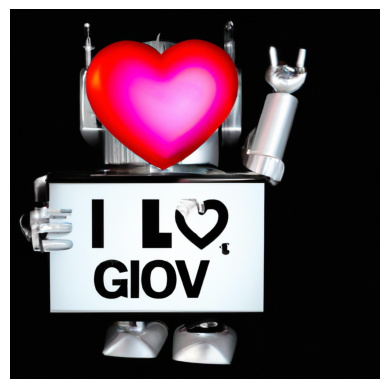

In [22]:
img = extract_img(dalle)

plt.imshow(img)
plt.axis("off")  # Turn off axis numbers
plt.show()

## Example With Critics: Iterate several times to improve

In [12]:
class DalleCreator(AssistantAgent):
    def __init__(self, n_iters=2, **kwargs):
        """
        Initializes a DalleCreator instance.

        This agent facilitates the creation of visualizations through a collaborative effort among
        its child agents: dalle and critics.

        Parameters:
            - n_iters (int, optional): The number of "improvement" iterations to run. Defaults to 2.
            - **kwargs: keyword arguments for the parent AssistantAgent.
        """
        super().__init__(**kwargs)  # 调用父类的初始化函数
        # register_reply函数用于注册一个回复函数，以便在满足特定条件时调用。在这个例子中，它注册了一个回复函数reply_func，当接收到消息的发送者是Agent类型且消息内容为None时，就会调用DalleCreator类的_reply_user函数。position=0参数指定了回复函数在回复列表中的位置。
        self.register_reply([Agent, None], reply_func=DalleCreator._reply_user, position=0)  # 注册回复函数
        self._n_iters = n_iters  # 设置改进迭代次数

    def _reply_user(self, messages=None, sender=None, config=None):
        if all((messages is None, sender is None)):
            error_msg = f"Either {messages=} or {sender=} must be provided."
            logger.error(error_msg)  # noqa: F821
            raise AssertionError(error_msg)

        if messages is None:
            messages = self._oai_messages[sender]

        img_prompt = messages[-1]["content"]  # 获取最后一条消息的内容作为图像提示

        ## Define the agents
        self.critics = MultimodalConversableAgent(
            name="Critics",
            system_message="""You need to improve the prompt of the figures you saw.
How to create a figure that is better in terms of color, shape, text (clarity), and other things.
Reply with the following format:

CRITICS: the image needs to improve...
PROMPT: here is the updated prompt!

""",
            llm_config={"config_list": config_list_4v, "max_tokens": 1000},
            human_input_mode="NEVER",
            max_consecutive_auto_reply=3,
        )  # 定义批评者代理

        self.dalle = DALLEAgent(
            name="Dalle", llm_config={"config_list": config_list_dalle}, max_consecutive_auto_reply=0
        )  # 定义DALLE代理

        # Data flow begins
        self.send(message=img_prompt, recipient=self.dalle, request_reply=True)  # 发送图像提示给DALLE代理
        img = extract_img(self.dalle)  # 提取DALLE代理的图像
        plt.imshow(img)  # 显示图像
        plt.axis("off")  # 关闭坐标轴数字
        plt.show()  # 显示图像
        print("Image PLOTTED")  # 打印信息

        for i in range(self._n_iters):
            # Downsample the image s.t. GPT-4V can take
            img = extract_img(self.dalle)  # 提取DALLE代理的图像
            smaller_image = img.resize((128, 128), Image.Resampling.LANCZOS)  # 缩小图像
            smaller_image.save("result.png")  # 保存图像为result.png

            self.msg_to_critics = f"""Here is the prompt: {img_prompt}.
            Here is the figure <img result.png>.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            """  
            # 构建消息给批评者
            self.send(message=self.msg_to_critics, recipient=self.critics, request_reply=True)  # 发送消息给批评者
            feedback = self._oai_messages[self.critics][-1]["content"]  # 获取批评者的反馈
            # 这段代码的含义是从反馈消息中提取新的图像提示。使用正则表达式re.findall("PROMPT: (.*)", feedback)来匹配以"PROMPT: "开头的内容，并将匹配到的内容作为新的图像提示。然后通过[0]来获取匹配到的内容。这段代码的作用是从批评者的反馈中提取新的图像提示，以便用于改进图像生成。
            img_prompt = re.findall("PROMPT: (.*)", feedback)[0]  # 从反馈中获取新的图像提示

            self.send(message=img_prompt, recipient=self.dalle, request_reply=True)  # 发送新的图像提示给DALLE代理
            img = extract_img(self.dalle)  # 提取DALLE代理的图像
            plt.imshow(img)  # 显示图像
            plt.axis("off")  # 关闭坐标轴数字
            plt.show()  # 显示图像
            print(f"Image {i} PLOTTED")  # 打印信息

        return True, "result.jpg"  # 返回True和结果图像文件名

User (to DALLE Creator!):

Create an image with black background, a happy robot is showing a sign with "I Love ZZ".

--------------------------------------------------------------------------------
[autogen.oai.client: 02-05 15:45:15] {349} WARNING - openai client was provided with an empty config_list, which may not be intended.
DALLE Creator! (to Dalle):

Create an image with black background, a happy robot is showing a sign with "I Love ZZ".

--------------------------------------------------------------------------------


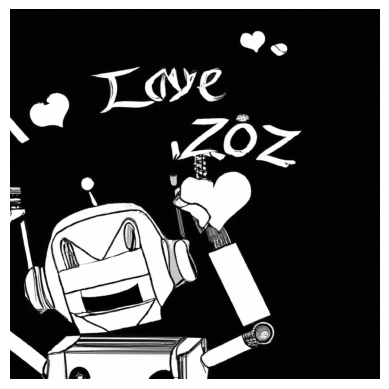

Image PLOTTED
DALLE Creator! (to Critics):

Here is the prompt: Create an image with black background, a happy robot is showing a sign with "I Love ZZ"..
            Here is the figure <image>.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            

--------------------------------------------------------------------------------
Critics (to DALLE Creator!):

CRITICS: The image needs improvement in the following areas:
- The text on the sign held by the robot appears to say "ZZ" instead of "ZZ," which might imply a typo or incorrect message.
- The robot could be made more visibly "happy" with a clear expression of joy.
- The contrast between the robot and the background might be enhanced for better clarity and visual appeal.
- The hearts floating around could be more vibrant or varied in size to add depth.

PROMPT: Create an image with a deep black background. In the center, design a cheerful ro

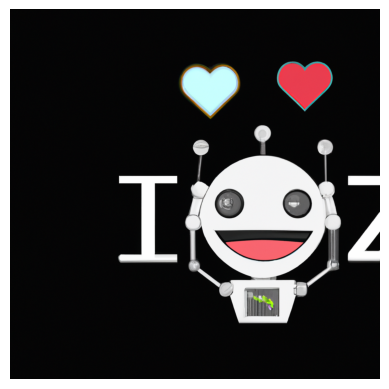

Image 0 PLOTTED
DALLE Creator! (to Critics):

Here is the prompt: Create an image with a deep black background. In the center, design a cheerful robot with bright, expressive eyes and a wide smile, showing a clear sign with the text "I Love ZZ" in bold, legible letters. Enhance the sign with a contrasting color like white or a bright shade to make the text stand out. Surround the robot with several hearts of different sizes with a slight glow to them to give the composition more life and vibrancy..
            Here is the figure <image>.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            

--------------------------------------------------------------------------------
Critics (to DALLE Creator!):

CRITICS: The image could be further improved in the following ways:
- The sign that the robot is supposed to be holding does not seem to be present; the letters "I" and "Z" are disconnected from a

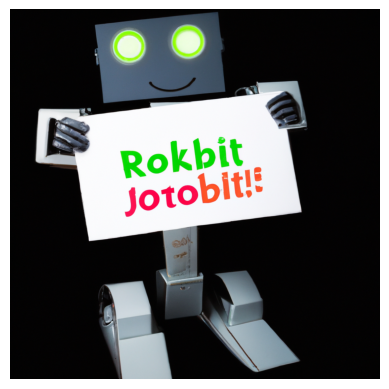

Image 1 PLOTTED
DALLE Creator! (to User):

result.jpg

--------------------------------------------------------------------------------


In [13]:
# 用dalle2的模型来跑，越跑效果越差。还是得看模型能力啊
creator = DalleCreator(
    name="DALLE Creator!",
    max_consecutive_auto_reply=0,
    system_message="Help me coordinate generating image",
    llm_config=gpt4_llm_config,
)

user_proxy = UserProxyAgent(
    name="User", 
    human_input_mode="NEVER", 
    max_consecutive_auto_reply=0,
    code_execution_config=False    # 不加这行代码会报错：RuntimeError: Code execution is set to be run in docker (default behaviour) but docker is not running.
)

user_proxy.initiate_chat(
    creator, message="""Create an image with black background, a happy robot is showing a sign with "I Love ZZ"."""
)